A camera I'm trying to support contains four microphones arranged 90° apart on the horizontal plane of the device. The microphones are MEMS components (PDF spec sheet [SPK0415HM4H-B](https://www.google.cz/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwjDsMqcicvKAhVLCBoKHdaoCtwQFggfMAA&url=http%3A%2F%2Fwww.knowles.com%2Feng%2Fcontent%2Fdownload%2F3897%2F49396%2Fversion%2F6%2Ffile%2FSPK0415HM4H-B.pdf&usg=AFQjCNFXrUBSm0OTjM3mrMi09nPyUxeOGA&sig2=i6jJaGOFd4R8CXFF62Yh0Q)) that generate a [pulse density modulated (PDM)](https://en.wikipedia.org/wiki/Pulse-density_modulation) signal. These components are common in digital devices where audio capture is desired in a small form factor, such as in cellular phones and small video cameras.

In order to capture high-quality audio with PDM devices, one must perform the following:

* Drive the PDM device with a high-frequency clock
* Record the pulse train with a decimating low-pass filter

According to the paper ["Understanding PDM Digital Audio"](http://users.ece.utexas.edu/~bevans/courses/rtdsp/lectures/10_Data_Conversion/AP_Understanding_PDM_Digital_Audio.pdf), a typical configuration for CD-quality audio is to drive the PDM device with a 3.072 MHz clock, then decimating the resulting pulse train by 64x to get a resulting sampling frequency of 48 kHz. This would then leave a final bandwidth of 24 kHz. While decimating, one must also perform low-pass filtering in order to keep noise in the +48 kHz bands from falling into the lower 0-24 kHz band due to aliasing.

The NumPy Python code below is my attempt to understand how all of this works. The approach I took is to first define a signal to be sampled (2 sin waves of differing frequencies). Next, I submit the signal to a pseudo-PDM processor that generates a pulse train of -1 and +1 values. These samples then flow into a decimation and low-pass filter, and I compare the resulting signal to see how well it matches with the original.

# Signal Creation

For simplicity, I am working in the low-frequency band. This should be immaterial since I believe it is just a scaling issue. Instead of 24 kHz bandwidth, I am working with 512 Hz. The signal that I created is made up of two sinusoids, one at 51 Hz and the other at 247 Hz.

In [1]:
figWidth = 16 # Width of many of the figures

sampleFrequency = 1024 # Hz
bandwidth = sampleFrequency / 2 # 0-512 Hz (also Nyquist freq)
sampleDuration = 1.0 / sampleFrequency # time duration per cycle

signalTime = np.arange(0, 1, sampleDuration)
signal1Freq = 51 # Hz
signal1Samples = np.sin(2.0 * np.pi * signal1Freq * signalTime)
signal2Freq = 247 # Hz
signal2Samples = np.sin(2.0 * np.pi * signal2Freq * signalTime)
signalSamples = (signal1Samples + signal2Samples) / 2

Below is a plot of the signal.

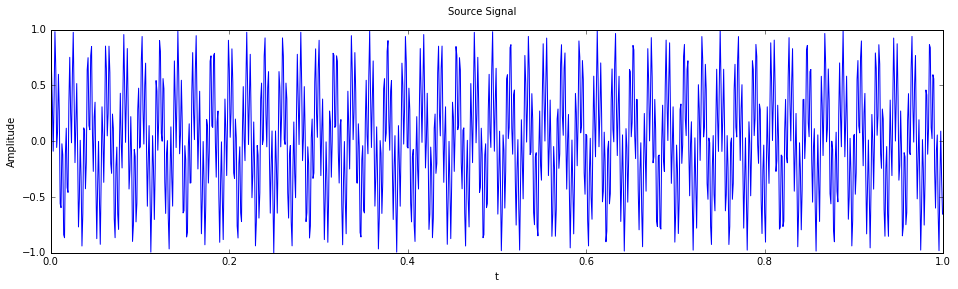

In [17]:
plt.figure(figsize=(figWidth, 4))
plt.plot(signalTime, signalSamples)
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.suptitle('Source Signal')
plt.show()

To verify that the signal really has only two frequency components, here is the output of the FFT for it.

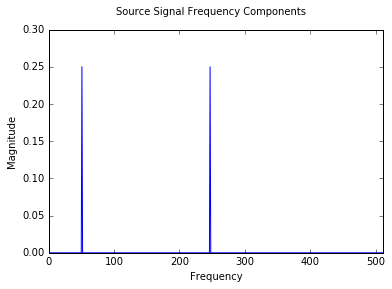

In [16]:
fftFreqs = np.arange(bandwidth)
fftValues = (np.fft.fft(signalSamples) / sampleFrequency)[:int(bandwidth)]
plt.plot(fftFreqs, np.absolute(fftValues))
plt.xlim(0, bandwidth)
plt.ylim(0, 0.3)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.suptitle("Source Signal Frequency Components")
plt.show()

# PDM Modulation

Now that we have a signal to work with, next step is to generate a pulse train from it. The code below is a simple hack that generates 64 samples for every one in the original signal. Normally, this would involve interpolation so that the 63 additional samples vary linearly from the previous sample to the current one. This lack will introduce some noise due to discontinuities.

The setting `pdmFreq` is the number of samples to create for each element in signalSamples.

In [4]:
pdmFreq = 64
pdmPulses = np.empty(sampleFrequency * pdmFreq)
pdmTime = np.arange(0, pdmPulses.size)

pdmIndex = 0
signalIndex = 0
quantizationError = 0
while pdmIndex < pdmPulses.size:
    sample = signalSamples[signalIndex]
    signalIndex += 1
    for tmp in range(pdmFreq):
        if sample >= quantizationError:
            bit = 1
        else:
            bit = -1
        quantizationError = bit - sample + quantizationError
        pdmPulses[pdmIndex] = bit
        pdmIndex += 1

print(pdmIndex, signalIndex, pdmPulses.size, signalSamples.size)

65536 1024 65536 1024


Visualize the first 4K PDM samples. We should be able to clearly see the pulsing.

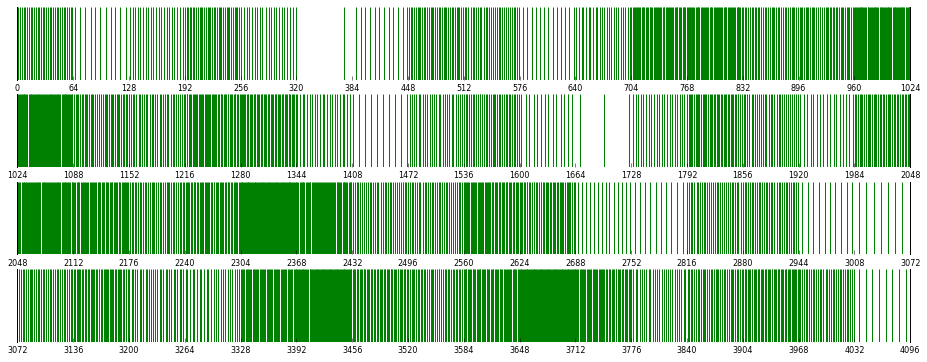

In [15]:
span = 1024
plt.figure(figsize=(16, 6))
counter = 1
for pos in range(0, pdmIndex, span):
    from matplotlib.ticker import MultipleLocator
    plt.subplot(4, 1, counter)
    counter += 1
    
    # Generate a set of time values that correspond to pulses with +1 values. Remove the rest
    # and plot.
    plt.vlines(np.delete(pdmTime[pos:pos + span], np.nonzero(pdmPulses[pos:pos + span] > 0.0)[0]), 0, 1, 'g')
    plt.ylim(0, 1)
    plt.xlim(pos, pos + span)
    plt.tick_params(axis='both', which='major', labelsize=8)
    ca = plt.gca()
    axes = ca.axes
    axes.yaxis.set_visible(False)
    # axes.yaxis.set_ticklabels([])
    axes.xaxis.set_ticks_position('bottom')
    # axes.xaxis.set_ticks(np.arange(pos, pos + span, 64))
    axes.xaxis.set_major_locator(MultipleLocator(64))
    spines = axes.spines
    for tag in ('top', 'bottom'):
        spines[tag].set_visible(False)
    if counter == 5:
        break
plt.show()

# Low-pass Filter

A fundamental nature of high-frequency sampling for PCM is that the noise from the quantization resulting from the PCM modulator is also of high-frequency (in a real system, there is also low-freq noise from clock jitter, heat, etc). When we decimate the signal, we do not want to bring the noise into the lower frequencies so we need to filter the samples before incorporating them into the new, lower-frequency signal. Our low-pass filter is a finite impulse response (FIR) type, with tap values
taken from the [TFilter](http://t-filter.engineerjs.com) web application.

Our filter is designed to operate at 2 x sampleFrequency so that it will cover our original bandwidth (512 Hz) in the pass-band and heavily attenuate everything else above.

[LowPassFilter.py source](LowPassFilter.py)

In [6]:
import LowPassFilter
lpf = LowPassFilter.LowPassFilter()

# PDM Decimation

Our PDM signal has a sampling frequency of 64 &times; sampleFrequency or 65.536 kHz. To get to our original sampleFrequency we need to ultimately use one sample out of every 64 we see in the PDM pulse train.

Since we want to filter out high-frequency noise, and our filter is tuned for 2 &times; sampleFrequency (2.048 kHz), will take every 32nd sample and send each to our filter, but with will only use every other filtered sample.

**NOTE**: the reconstruction here of a sample value from PDM values is *not* what would really take place. In particular, the code below obtains an average of the +/- unity values in the chain, where a real implementation would count bits and convert into a sample value.

In [7]:
derivedSamples = []
pdmIndex = 0
while pdmIndex < pdmPulses.size:
    lpf(pdmPulses[int(pdmIndex)])
    pdmIndex += pdmFreq / 2
    filtered = lpf(pdmPulses[int(pdmIndex)])
    pdmIndex += pdmFreq / 2
    derivedSamples.append(filtered)
derivedSamples = np.array(derivedSamples)

signalSamples.size, derivedSamples.size

(1024, 1024)

Now plots of the resulting signal in both time and frequency domains

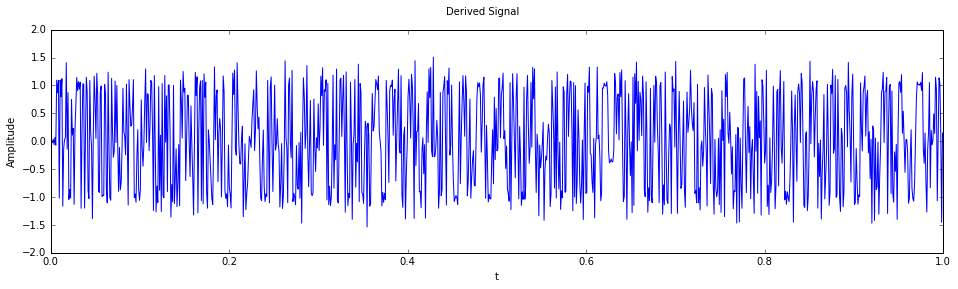

In [14]:
plt.figure(figsize=(figWidth, 4))
plt.plot(signalTime, derivedSamples)
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.suptitle('Derived Signal')
plt.show()

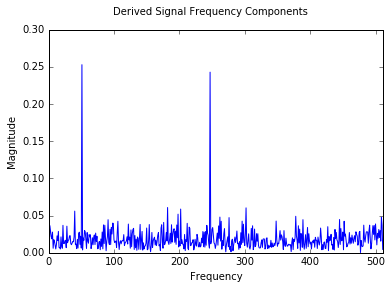

In [11]:
fftFreqs = np.arange(bandwidth)
fftValues = (np.fft.fft(derivedSamples) / sampleFrequency)[:int(bandwidth)]
plt.plot(fftFreqs, np.absolute(fftValues))
plt.xlim(0, bandwidth)
plt.ylim(0, 0.3)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.suptitle("Derived Signal Frequency Components")
plt.show()

# Filtering Test

Let's redo the PCM modulation / decimation steps but this time while injecting a high-frequency (32.767 kHz) signal with 30% intensity during the modulation. Hopefully, we will not see this noise appear in the final result.

In [18]:
pdmFreq = 64
pdmPulses = np.empty(sampleFrequency * pdmFreq)
pdmTime = np.arange(0, pdmPulses.size)

pdmIndex = 0
signalIndex = 0
quantizationError = 0

noiseFreq = 32767 # Hz
noiseAmplitude = .30
noiseSampleDuration = 1.0 / (sampleFrequency * pdmFreq)
noiseTime = np.arange(0, 1, noiseSampleDuration)
noiseSamples = np.sin(2.0 * np.pi * noiseFreq * noiseTime) * noiseAmplitude

while pdmIndex < pdmPulses.size:
    sample = signalSamples[signalIndex] + noiseSamples[pdmIndex]
    signalIndex += 1
    for tmp in range(pdmFreq):
        if sample >= quantizationError:
            bit = 1
        else:
            bit = -1
        quantizationError = bit - sample + quantizationError
        pdmPulses[pdmIndex] = bit
        pdmIndex += 1

print(pdmIndex, signalIndex, pdmPulses.size, signalSamples.size, noiseSamples.size)

65536 1024 65536 1024 65536


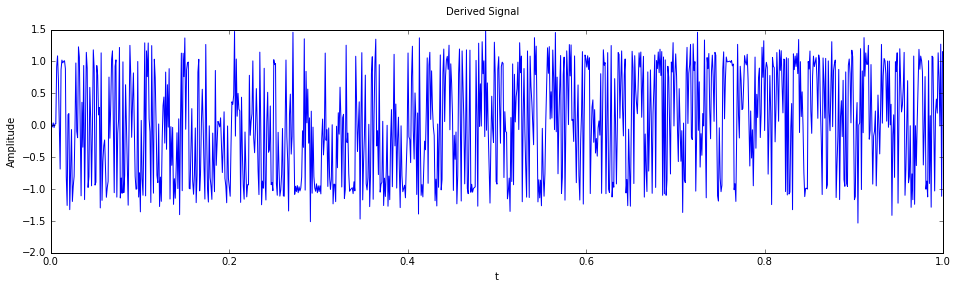

In [20]:
derivedSamples = []
pdmIndex = 0
lpf.reset()
while pdmIndex < pdmPulses.size:
    lpf(pdmPulses[int(pdmIndex)])
    pdmIndex += pdmFreq / 2
    filtered = lpf(pdmPulses[int(pdmIndex)])
    pdmIndex += pdmFreq / 2
    derivedSamples.append(filtered)
derivedSamples = np.array(derivedSamples)

plt.figure(figsize=(figWidth, 4))
plt.plot(signalTime, derivedSamples)
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.suptitle('Derived Signal')
plt.show()

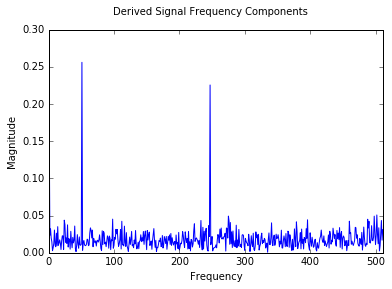

In [21]:
fftFreqs = np.arange(bandwidth)
fftValues = (np.fft.fft(derivedSamples) / sampleFrequency)[:int(bandwidth)]
plt.plot(fftFreqs, np.absolute(fftValues))
plt.xlim(0, bandwidth)
plt.ylim(0, 0.3)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.suptitle("Derived Signal Frequency Components")
plt.show()

Not bad. There is some noticable attenuation of the 256 Hz signal, but the noise floor does not look much different than the plot without the injected noise.

# Further Work

The filtering above is expensive, requiring 32 multiplications per sample. The main alternative is a [cascaded-integrator comb filter](https://en.wikipedia.org/wiki/Cascaded_integrator–comb_filter) which only uses additions. 

There is a [interesting work](http://curiouser.cheshireeng.com/2015/07/17/more-dynamic-range-in-the-splear-pdm-conversion/) published by Cheshire Engineering that describes in detail how to integrate a PCM device with small, low-powered devices. They make available C code that performs CIC filtering.

## Additional Reading

[Design and Implementation of Efficient CIC Filter Structure for Decimation](https://www.researchgate.net/publication/236902691_Design_and_Implementation_of_Efficient_CIC_Filter_Structure_for_Decimation)

[Understanding Cascaded Integrator Comb Filters](http://www.design-reuse.com/articles/10028/understanding-cascaded-integrator-comb-filters.html)

[Example of Cascaded Integrator Comb Filter in Matlab](http://www.dsplog.com/2007/07/01/example-of-cascaded-integrator-comb-filter-in-matlab/)